In [28]:
import pandas as pd

# Init data set

In [29]:
sentence_df = pd.read_csv("data/MIMIC III per sentence annotated dataset - Sheet1.csv")[:10000]
sentence_df

,sentence,code
0,pt transferred to [**hospital unit name 4**] c...,J80
1,chb d/t hypothyroidism--pt with recent hx of n...,E039
2,the patient is a 67-year-old female with a his...,I4891
3,"rca, htn, gerd, left knee replacement, bipolar...",F319
4,chronic obstructive pulmonary disease diabetes...,E119
...,...,...
9995,recent intraparenchymal hemorrhage and cardiac...,I469
9996,"40 year-old woman with chf, htn, copd, morbid...",E6601
9997,[**known lastname **] died of cardiac arrest,I469
9998,"coronary artery disease s/p ptca, heart failu...",K219


In [30]:
sentence_df.isna().sum()

sentence    0
code        0
dtype: int64

In [31]:
len(sentence_df['code'].value_counts(normalize = True))

49

<AxesSubplot:>

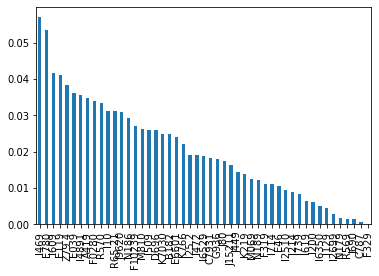

In [32]:
sentence_df['code'].value_counts(normalize = True).plot.bar()

## Text Preprocessing

In [33]:
import re

import nltk
nltk.download("all")


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package basque_grammars is alread

In [34]:
# create a list text
preprocessed_df = sentence_df.copy(deep=True)
text = list(preprocessed_df["sentence"])
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(len(text)):

    r = re.sub("[^a-zA-Z]", " ", text[i])
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words("english")]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = " ".join(r)

    corpus.append(r)

preprocessed_df["sentence"] = corpus
preprocessed_df.head()


,sentence,code
0,pt transferred hospital unit name c respirator...,J80
1,chb hypothyroidism pt recent hx non compliance...,E039
2,patient year old female history chronic renal ...,I4891
3,rca htn gerd left knee replacement bipolar dis...,F319
4,chronic obstructive pulmonary disease diabetes...,E119


## Train-test split

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [60]:
X = preprocessed_df["sentence"]
y = preprocessed_df["code"]

# max_features=500 it's needed because time for processing takes a lot of time
# tfidfconverter = TfidfVectorizer(
#     max_features=500, stop_words=stopwords.words("english")
# )
vectorizer = HashingVectorizer(n_features=1000)
X = vectorizer.fit_transform(preprocessed_df["sentence"]).toarray()
X.shape


(10000, 1000)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=123
)


print("Training Data :", X_train.shape)
print("Testing Data : ", X_test.shape)


Training Data : (6700, 1000)
Testing Data :  (3300, 1000)


## Training RandomForest model

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [74]:
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [75]:
y_pred = classifier.predict(X_test)

In [79]:
y_pred

array(['I6350', 'J449', 'E6601', ..., 'E119', 'E46', 'J449'], dtype=object)

In [76]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[105   0   0 ...   2   0   0]
 [  0  64   0 ...   0   0   2]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ... 103   5   1]
 [  0   0   0 ...   1  96   0]
 [  0   0   0 ...   0   0 113]]
              precision    recall  f1-score   support

        A419       0.95      0.92      0.93       114
        B182       0.88      0.82      0.85        78
        C787       1.00      1.00      1.00         1
       C7931       0.98      0.98      0.98        58
        D696       0.95      0.82      0.88        97
        E039       0.78      0.63      0.70       126
        E119       0.56      0.85      0.67       125
         E46       0.91      0.74      0.82        39
       E6601       0.87      0.91      0.89        82
        E780       0.73      0.91      0.81       171
       F0280       0.88      0.89      0.89       119
      F10239       0.96      0.97      0.97        73
        F319       0.77      0.69      0.73        29
        G936       0.97      0.98      0.97        

## Save model

In [42]:
import pickle

In [77]:
pickle.dump(classifier, open("./first_service/models/random_forest_model.pickle", "wb"))

In [78]:
pickle.dump(vectorizer, open("./first_service/models/vectorizer.pickle", "wb"))